In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
sys.path.insert(0,"..")

In [3]:
import time
from collections import OrderedDict
from options.train_options import TrainOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
import util.util as util
import os
import numpy as np
import torch
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import cv2

?


In [4]:
writer = SummaryWriter('runs/G1G2')
SIZE=320
NC=14
def generate_label_plain(inputs):
    size = inputs.size()
    pred_batch = []
    for input in inputs:
        input = input.view(1, NC, 256,192)
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)

    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_batch = pred_batch.view(size[0], 1, 256,192)

    return label_batch

def generate_label_color(inputs):
    label_batch = []
    for i in range(len(inputs)):
        label_batch.append(util.tensor2label(inputs[i], opt.label_nc))
    label_batch = np.array(label_batch)
    label_batch = label_batch * 2 - 1
    input_label = torch.from_numpy(label_batch)

    return input_label
def complete_compose(img,mask,label):
    label=label.cpu().numpy()
    M_f=label>0
    M_f=M_f.astype(np.int)
    M_f=torch.FloatTensor(M_f).cuda()
    masked_img=img*(1-mask)
    M_c=(1-mask.cuda())*M_f
    M_c=M_c+torch.zeros(img.shape).cuda()##broadcasting
    return masked_img,M_c,M_f

def compose(label,mask,color_mask,edge,color,noise):
    # check=check>0
    # print(check)
    masked_label=label*(1-mask)
    masked_edge=mask*edge
    masked_color_strokes=mask*(1-color_mask)*color
    masked_noise=mask*noise
    return masked_label,masked_edge,masked_color_strokes,masked_noise
def changearm(old_label):
    label=old_label
    arm1=torch.FloatTensor((data['label'].cpu().numpy()==11).astype(np.int))
    arm2=torch.FloatTensor((data['label'].cpu().numpy()==13).astype(np.int))
    noise=torch.FloatTensor((data['label'].cpu().numpy()==7).astype(np.int))
    label=label*(1-arm1)+arm1*4
    label=label*(1-arm2)+arm2*4
    label=label*(1-noise)+noise*4
    return label

In [5]:
!pwd

/home/hz/tryon/test_src/notebooks


In [6]:
os.makedirs('../sample_eda',exist_ok=True)

os.makedirs('../fake',exist_ok=True)
opt = TrainOptions().parse()

## Load models
opt.load_pretrain = '../checkpoints/acgpn_all'
#opt.load_pretrain = '../checkpoints/acgpn_5000'

# Change to run on notebook
opt.dataroot = "../../datasets/acgpn_data/try_on_testing/"

iter_path = os.path.join(opt.checkpoints_dir, opt.name, 'iter.txt')
print(opt.load_pretrain)

------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
data_type: 32
dataroot: ../datasets/acgpn_data/try_on_testing/
debug: False
display_freq: 100
display_winsize: 512
fineSize: 512
gpu_ids: [0]
input_nc: 3
isTrain: True
label_nc: 20
lambda_feat: 10.0
loadSize: 512
load_pretrain: ./checkpoints/label2city
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: test
pool_size: 0
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 10
save_latest_freq: 1000
serial_batches: False
tf_log: False
use_dropout: False
verbose: False
which_epoch: latest
-------------- End ----------------
../checkpoints/acgpn_

In [7]:
opt

Namespace(batchSize=1, beta1=0.5, checkpoints_dir='./checkpoints', continue_train=False, data_type=32, dataroot='../../datasets/acgpn_data/try_on_testing/', debug=False, display_freq=100, display_winsize=512, fineSize=512, gpu_ids=[0], input_nc=3, isTrain=True, label_nc=20, lambda_feat=10.0, loadSize=512, load_pretrain='../checkpoints/acgpn_all', lr=0.0002, max_dataset_size=inf, model='pix2pixHD', nThreads=2, n_blocks_global=4, n_blocks_local=3, n_downsample_global=4, n_layers_D=3, n_local_enhancers=1, name='label2city', ndf=64, netG='global', ngf=64, niter=100, niter_decay=100, niter_fix_global=0, no_flip=False, no_ganFeat_loss=False, no_html=False, no_lsgan=False, no_vgg_loss=False, norm='instance', num_D=2, output_nc=3, phase='test', pool_size=0, print_freq=100, resize_or_crop='scale_width', save_epoch_freq=10, save_latest_freq=1000, serial_batches=False, tf_log=False, use_dropout=False, verbose=False, which_epoch='latest')

In [8]:
if opt.continue_train:
    try:
        start_epoch, epoch_iter = np.loadtxt(iter_path , delimiter=',', dtype=int)
    except:
        start_epoch, epoch_iter = 1, 0
    print('Resuming from epoch %d at iteration %d' % (start_epoch, epoch_iter))        
else:    
    start_epoch, epoch_iter = 1, 0

In [9]:
start_epoch

1

In [10]:
if opt.debug:
    opt.display_freq = 1
    opt.print_freq = 1
    opt.niter = 1
    opt.niter_decay = 0
    opt.max_dataset_size = 10   

In [11]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
print('# Inference images = %d' % dataset_size)

CustomDatasetDataLoader
dataset [AlignedDataset] was created
../../datasets/acgpn_data/try_on_testing/test_label label
../../datasets/acgpn_data/try_on_testing/test_label label
../../datasets/acgpn_data/try_on_testing/test_img img
../../datasets/acgpn_data/try_on_testing/test_img img
../../datasets/acgpn_data/try_on_testing/test_edge edge
../../datasets/acgpn_data/try_on_testing/test_edge edge
../../datasets/acgpn_data/try_on_testing/test_mask mask
../../datasets/acgpn_data/try_on_testing/test_mask mask
../../datasets/acgpn_data/try_on_testing/test_colormask colormask
../../datasets/acgpn_data/try_on_testing/test_colormask colormask
../../datasets/acgpn_data/try_on_testing/test_color color
../../datasets/acgpn_data/try_on_testing/test_color color
# Inference images = 2032


### Model

In [12]:
model = create_model(opt)

latest_net_U.pth
latest_net_G1.pth
latest_net_G2.pth
latest_net_G.pth


In [13]:
total_steps = (start_epoch-1) * dataset_size + epoch_iter

display_delta = total_steps % opt.display_freq
print_delta = total_steps % opt.print_freq
save_delta = total_steps % opt.save_latest_freq

In [14]:
data_dummy = next(iter(dataset))

/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode ins

In [15]:
data_dummy.keys()

dict_keys(['label', 'label_ref', 'image', 'image_ref', 'path', 'path_ref', 'edge', 'color', 'mask', 'colormask', 'pose', 'name'])

In [16]:
data_dummy['path'], data_dummy['path_ref'], data_dummy['name']

(['../../datasets/acgpn_data/try_on_testing/test_label/009205_0.png'],
 ['../../datasets/acgpn_data/try_on_testing/test_label/011495_0.png'],
 ['009205_0.jpg'])

In [17]:
data_dummy['image'].shape

torch.Size([1, 3, 256, 192])

In [18]:
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [19]:
A = cv2.imread(data_dummy['path'][0], -1)
B = cv2.imread(data_dummy['path_ref'][0], -1)

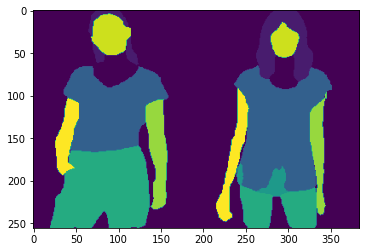

In [20]:
img_stack = np.hstack((A, B))
plt.imshow(img_stack)
plt.show()

In [21]:
opt.niter

100

In [22]:
opt.niter_decay

100

In [23]:
start_epoch, opt.niter + opt.niter_decay + 1

(1, 201)

In [24]:
import pytorch_ssim
import torch
from torch.autograd import Variable

In [25]:
step = 0 
ssims = []

for epoch in range(start_epoch, opt.niter + opt.niter_decay + 1):
    #import ipdb; ipdb.set_trace()
    
    epoch_start_time = time.time()
    if epoch != start_epoch:
        epoch_iter = epoch_iter % dataset_size
        
    # iterate over the dataset
    for i, data in enumerate(dataset, start=epoch_iter):

        iter_start_time = time.time()
        total_steps += opt.batchSize
        epoch_iter += opt.batchSize

        # whether to collect output images
        #save_fake = total_steps % opt.display_freq == display_delta
        save_fake = True

        ##add gaussian noise channel
        ## wash the label
        t_mask = torch.FloatTensor((data['label'].cpu().numpy() == 7).astype(np.float))
        #
        # data['label'] = data['label'] * (1 - t_mask) + t_mask * 4
        mask_clothes = torch.FloatTensor((data['label'].cpu().numpy() == 4).astype(np.int))
        mask_fore = torch.FloatTensor((data['label'].cpu().numpy() > 0).astype(np.int))
        img = data['image'].float().cuda()
        img_fore = data['image'] * mask_fore
        img_fore_wc = img_fore * mask_fore
        all_clothes_label = changearm(data['label'])

        ############## Forward Pass ######################
        losses, fake_image, real_image, input_label,L1_loss,style_loss,clothes_mask,CE_loss,rgb,alpha= model(Variable(data['label'].cuda()),Variable(data['edge'].cuda()),Variable(img_fore.cuda()),Variable(mask_clothes.cuda())
                                                                                                    ,Variable(data['color'].cuda()),Variable(all_clothes_label.cuda()),Variable(data['image'].cuda()),Variable(data['pose'].cuda()) ,Variable(data['image'].cuda()) ,Variable(mask_fore.cuda()))
        
        # sum per device losses
        losses = [ torch.mean(x) if not isinstance(x, int) else x for x in losses ]
        loss_dict = dict(zip(model.module.loss_names, losses))

        # calculate final loss scalar
        loss_D = (loss_dict['D_fake'] + loss_dict['D_real']) * 0.5
        loss_G = loss_dict['G_GAN']+torch.mean(CE_loss)#loss_dict.get('G_GAN_Feat',0)+torch.mean(L1_loss)+loss_dict.get('G_VGG',0)

        writer.add_scalar('loss_d', loss_D, step)
        writer.add_scalar('loss_g', loss_G, step)
        writer.add_scalar('loss_CE', torch.mean(CE_loss), step)
        writer.add_scalar('loss_g_gan', loss_dict['G_GAN'], step)

        ############## Display results and errors ##########

        
        ### display output images
        a = generate_label_color(generate_label_plain(input_label)).float().cuda()
        b = real_image.float().cuda()
        c = fake_image.float().cuda()
        d=torch.cat([clothes_mask,clothes_mask,clothes_mask],1)
        combine = torch.cat([a[0],d[0],b[0],c[0],rgb[0]], 2).squeeze()
        # combine=c[0].squeeze()
        cv_img=(combine.permute(1,2,0).detach().cpu().numpy()+1)/2
        if step % 1 == 0:
            writer.add_image('combine', (combine.data + 1) / 2.0, step)
            rgb=(cv_img*255).astype(np.uint8)
            bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
            n=str(step)+'.jpg'
            cv2.imwrite('../sample_eda/'+data['name'][0],bgr)
            
            #########################################
            #import ipdb; ipdb.set_trace()
            
            # Save tryon images
            fake_i =(fake_image[0].permute(1,2,0).detach().cpu().numpy()+1)/2
            fake_i=(fake_i*255).astype(np.uint8)
            fake_i=cv2.cvtColor(fake_i,cv2.COLOR_RGB2BGR)
            cv2.imwrite('../fake/'+data['name'][0],fake_i)
            #########################################
            
        step += 1
        print(step)
        
        
        #import ipdb; ipdb.set_trace()
        
        ##################################################
        # Compute SSIM scores
        def norm(tensor_list):
            mins = tensor_list.min()
            maxs = tensor_list.max()
            normalized_data = (tensor_list - mins) / (maxs - mins)
            return normalized_data
        
        # Normalize image to [0-1]
        real_norm = norm(img)
        fake_norm = norm(fake_image)

        score = pytorch_ssim.ssim(real_norm, fake_norm)
        score = score.item()
        print("SSIM for {}-----:".format(step), score)
        ssims.append(score)
        ##################################################
        
        ### save latest model
        if total_steps % opt.save_latest_freq == save_delta:
            # print('saving the latest model (epoch %d, total_steps %d)' % (epoch, total_steps))
            # model.module.save('latest')
            # np.savetxt(iter_path, (epoch, epoch_iter), delimiter=',', fmt='%d')
            pass
        if epoch_iter >= dataset_size:
            break

        # Debug
#         if i == 10:
#             print("Exiting loop.")
#             #i = 0
#             break
       
    # end of epoch 
    iter_end_time = time.time()
    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))
    break

    ### save model for this epoch
    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_steps))        
        model.module.save('latest')
        model.module.save(epoch)
        # np.savetxt(iter_path, (epoch+1, 0), delimiter=',', fmt='%d')

    ### instead of only training the local enhancer, train the entire network after certain iterations
    if (opt.niter_fix_global != 0) and (epoch == opt.niter_fix_global):
        model.module.update_fixed_params()

    ### linearly decay learning rate after certain iterations
    if epoch > opt.niter:
        model.module.update_learning_rate()

/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode ins

1
SSIM for 1-----: 0.8871380686759949
2
SSIM for 2-----: 0.8752884864807129
3
SSIM for 3-----: 0.892206609249115
4
SSIM for 4-----: 0.8976848721504211
5
SSIM for 5-----: 0.837234616279602
6
SSIM for 6-----: 0.9406956434249878
7
SSIM for 7-----: 0.9109814167022705
8
SSIM for 8-----: 0.8778030872344971
9
SSIM for 9-----: 0.8924007415771484
10
SSIM for 10-----: 0.945599377155304
11
SSIM for 11-----: 0.8331503868103027
12
SSIM for 12-----: 0.8524619340896606
13
SSIM for 13-----: 0.9446514248847961
14
SSIM for 14-----: 0.9315997362136841
15
SSIM for 15-----: 0.8970234990119934
16
SSIM for 16-----: 0.915546715259552
17
SSIM for 17-----: 0.8017138242721558
18
SSIM for 18-----: 0.8896072506904602
19
SSIM for 19-----: 0.9405872821807861
20
SSIM for 20-----: 0.9031252264976501
21
SSIM for 21-----: 0.8542056679725647
22
SSIM for 22-----: 0.9319987893104553
23
SSIM for 23-----: 0.9063240885734558
24
SSIM for 24-----: 0.9481624960899353
25
SSIM for 25-----: 0.9139063358306885
26
SSIM for 26-----: 0

# Compute SSIM score

In [26]:
score = np.array(ssims).mean()
print("SSIM score: {:.4f}".format(score))

# Higgher the better
# acgpn_all , 0.8727
# acgpn_5000, 0.8264

SSIM score: 0.8727


In [27]:
# a =(img[0].permute(1,2,0).detach().cpu().numpy()+1)/2
# b =(fake_image[0].permute(1,2,0).detach().cpu().numpy()+1)/2

# a.shape, b.shape

# plt.imshow(a)
# plt.imshow(b)

# Compute FID scores

In [28]:
!python -m pytorch_fid ../fake ../../datasets/acgpn_data/try_on_testing/test_img

/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
FID:  12.852613650170923


In [29]:
# Lower the better
# With test_img itself, FID:  -4.0183

# For acgpn_all (all data), FID:  12.852
# For acgpn_5000, FID:  23.26205

In [30]:
!python -m pytorch_fid ../../datasets/acgpn_data/try_on_testing/test_img ../../datasets/acgpn_data/try_on_testing/test_img

/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
FID:  -4.018301240193978e-06
